## In this section I will be doing data clean up and features selection and creation

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import itertools

In [2]:
BALL_BY_BALL=pd.read_csv('BALL_BY_BALL.csv')

In [3]:
BALL_BY_BALL['DISS'] = np.where( BALL_BY_BALL['OUT']==True, 1, 0)

In [4]:
BALL_BY_BALL.shape

(1226357, 16)

there are 1226357 records with 15 columns

### Now I will choose two teams from IPL 2019 fo the model

In [6]:
dream_11_df=pd.read_csv('teams.csv')

In [13]:
dream_11_df

,PLAYER_NAME,PLAYER_ID,TEAM,POS,INN,GROUND,TYPE,CR
0,SR Watson,8180,CSK,1,1,MA Chidambaram Stadium Chepauk Chennai,BAT,10.0
1,F du Plessis,44828,CSK,2,1,MA Chidambaram Stadium Chepauk Chennai,BAT,9.0
2,SK Raina,33335,CSK,3,1,MA Chidambaram Stadium Chepauk Chennai,BAT,9.5
3,MS Dhoni,28081,CSK,4,1,MA Chidambaram Stadium Chepauk Chennai,WK,9.0
4,AT Rayudu,33141,CSK,5,1,MA Chidambaram Stadium Chepauk Chennai,BAT,9.5
5,KM Jadhav,290716,CSK,6,1,MA Chidambaram Stadium Chepauk Chennai,BAT,9.0
6,SC Kuggeleijn,539548,CSK,7,1,MA Chidambaram Stadium Chepauk Chennai,BOL,8.0
7,RA Jadeja,234675,CSK,8,1,MA Chidambaram Stadium Chepauk Chennai,ALL,8.5
8,Harbhajan Singh,29264,CSK,9,1,MA Chidambaram Stadium Chepauk Chennai,BOL,8.0
9,DL Chahar,447261,CSK,10,1,MA Chidambaram Stadium Chepauk Chennai,BOL,8.5


#### The above data is from fantacy cricket data

# In The below section we will create all the functions that are requried to create new features

In [17]:
def batting_profile(battsmen_id,inn):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BATSMEN_ID == battsmen_id) & (BALL_BY_BALL.INN == inn)]
    summary=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME','GROUND','INN']).agg({'BALL':'max'}).reset_index()
    return summary

In [18]:
def ground_performance_bat(match_num,ground,pos,inn):
    ground_data=BALL_BY_BALL[(BALL_BY_BALL.GROUND == ground)&(BALL_BY_BALL.INN == inn) &(BALL_BY_BALL.MATCH_NUMBER <= match_num)]
    order=ground_data.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME','INN']).agg({'BALL':['min','max'],'RUNS':'sum'},axis=0 ).reset_index()
    order.columns = ['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME','INN','RUNS','FIRST','LAST']
    order['POS']=order.groupby(['MATCH_NUMBER','INN'])['FIRST'].rank(ascending=True)
    order=order[(order.POS==pos)]
    avg_out=order.LAST.mean()
    return avg_out

In [19]:
def Batting_order(match_num,inn,batsmen_id):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num) & (BALL_BY_BALL.INN == inn)]
    order=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME']).agg({'BALL':['min','max'],'RUNS':'sum'}).reset_index()
    order.columns = ['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME','RUNS','FIRST','LAST']
    order['POS']=order.groupby('MATCH_NUMBER')['FIRST'].rank(ascending=True)
    order=order[(order.BATSMEN_ID==batsmen_id)]
    pos=order.POS.max()
    over_started=order.FIRST.max()
    over_ended=order.LAST.max()
    return [over_started,pos,over_ended]

In [20]:
def batsmen_avg_out(match_num,batsmen_id,pos,inn):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BATSMEN_ID == batsmen_id)&
                            (BALL_BY_BALL.INN == inn)&
                            (BALL_BY_BALL.MATCH_NUMBER <= match_num)]
    summary=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','INN']).agg({'BALL':'min','RUNS':'sum'}).reset_index()
    avg_out=[]
    cnt=0
    for ind,row in summary.iterrows():
        lst=Batting_order(row['MATCH_NUMBER'],row['INN'],row['BATSMEN_ID'])
        position=lst[1]
        over_ended=lst[2]
        if position==pos:
            avg_out.insert(cnt,over_ended)
            cnt=cnt+1
    out=np.mean(avg_out)
    return out

In [21]:
def Batting_order_wicket(match_num,inn,bower_id,pos):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num) & (BALL_BY_BALL.INN == inn)]
    order=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME']).agg({'BALL':['min','max'],'RUNS':'sum'}).reset_index()
    order.columns = ['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME','RUNS','FIRST','LAST']
    order['POS']=order.groupby('MATCH_NUMBER')['FIRST'].rank(ascending=True)
    wiket_balls=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == bower_id)& (BALL_BY_BALL.INN == inn) & (BALL_BY_BALL.OUT == True)]
    wiket_balls=wiket_balls[['BOWLER_NAME','BATSMEN_NAME','BOWLER_ID','BATSMEN_ID','BALL']]
    df = pd.merge(wiket_balls,order, how='inner', on=['BATSMEN_ID'])
    df=df[(df.POS == pos)]
    final_avg_out=df.LAST.mean()
        
    return final_avg_out

In [22]:
def pos_avg_bowling(match_num,ground,pos,bower_id,inn):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER <= match_num) &(BALL_BY_BALL.BOWLER_ID == bower_id) & (BALL_BY_BALL.GROUND == ground) & (BALL_BY_BALL.INN == inn)]
    summary=player_dat.groupby(['MATCH_NUMBER','INN','BOWLER_ID','BOWLER_NAME']).agg({'BALL':'count','DISS':'sum'}).reset_index()
    out_ball_lst=[]
    x=0
    for ind,row in summary.iterrows():
        out_ball=Batting_order_wicket(row['MATCH_NUMBER'],row['INN'],row['BOWLER_ID'],pos)
        if out_ball>=0.0:
            out_ball_lst.insert(x,out_ball)
            x=x+1
    return out_ball_lst

In [23]:
def bowlers_faced_by_batsmen(ground,pos,match_num,inn):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num)]
    summary=player_dat.groupby(['BOWLER_ID','BOWLER_NAME']).agg({'BALL':'count','DISS':'sum'}).reset_index()
    ball_list=[]
    for ind,row in summary.iterrows():
        lst=pos_avg_bowling(match_num,ground,pos,row['BOWLER_ID'],inn)
        ball_list=ball_list+lst
    if len(ball_list)==0:
        avg_ball=0
    else:
        avg_ball=round(sum(ball_list)/len(ball_list),2)
    return avg_ball

In [24]:
def bol_vs_bat(match_num,bowler_id,batsmen_id,):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER <= match_num) &(BALL_BY_BALL.BOWLER_ID == bowler_id) & (BALL_BY_BALL.BATSMEN_ID == batsmen_id) & (BALL_BY_BALL.OUT == True)]
    order=player_dat.groupby(['MATCH_NUMBER']).agg({'BALL':['min','max']}).reset_index()
    order.columns = ['MATCH_NUMBER','FIRST','LAST']
    mean_last_ball=order.LAST.mean()
    if math.isnan(mean_last_ball):
        return 0
    else:
        return mean_last_ball

In [25]:
def bowlers_vs_batsmen(pos,batsmen_id,match_num):   
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num) & (BALL_BY_BALL.BATSMEN_ID == batsmen_id)]  
    summary=player_dat.groupby(['MATCH_NUMBER','INN','BATSMEN_ID','BOWLER_ID']).agg({'BALL':'count','DISS':'sum'}).reset_index()
    lst=[]
    x=0
    for ind,row in summary.iterrows():
        val=bol_vs_bat(row['MATCH_NUMBER'],row['BOWLER_ID'],row['BATSMEN_ID'])
        position=Batting_order(row['MATCH_NUMBER'],row['INN'],row['BATSMEN_ID'])[1]
        if val >0 and position ==pos:
            lst.insert(x,val)
            x=x+1
    if len(lst) >0:
        mean_val=round(sum(lst)/len(lst),2)
    else:
        mean_val=0
    return mean_val 

In [26]:
def return_bolwer_list(team):
    player_data=dream_11_df[(dream_11_df.TEAM != team)]
    bowler_list=list(player_data.PLAYER_ID.unique())
    return bowler_list

In [27]:
def bowling_profile(bowler_id):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == bowler_id)]
    summary=player_dat.groupby(['MATCH_NUMBER','BOWLER_ID','BOWLER_NAME','GROUND','INN']).agg({'BALL':'count','RUNS':'sum','DISS':'sum'}).reset_index()
    summary['WICKETS']=summary['DISS']*20
    return summary


In [28]:
def ground_avg_bol(ground,bowler_id):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == bowler_id) & (BALL_BY_BALL.GROUND == ground)]
    summary=player_dat.groupby(['MATCH_NUMBER']).agg({'BALL':'count','RUNS':'sum','DISS':'sum'}).reset_index()
    summary['WICKETS']=summary['DISS']*20
    avg=summary.WICKETS.mean()
    if len(player_dat)>0:
        return avg
    else:
        return 0.0

In [29]:
def head_to_head(bowler,batsmen):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == bowler) & (BALL_BY_BALL.BATSMEN_ID == batsmen)]
    summary=player_dat.groupby(['MATCH_NUMBER','BOWLER_ID','BOWLER_NAME']).agg({'BALL':'count','RUNS':'sum','DISS':'sum'}).reset_index()
    summary['WICKETS']=summary['DISS']*20
    avg_wk=summary.WICKETS.mean()
    if len(summary)>0:
        return avg_wk
    else:
        return 0.0

In [30]:
def get_batsmen_avg(bowler_id,match_num):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num)]
    batsmen_list=list(player_dat.BATSMEN_ID.unique())
    lst=[]
    x=0
    for bat in batsmen_list:
        val = head_to_head(bowler_id,bat)
        lst.insert(x,val)
        x=x+1
    if len(lst)>0:
        avg=np.mean(lst)
    else:
        avg=0
    return avg

In [31]:
def cal_totla_runs_wikets_rem(match_num,pos):
    match_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num) & (BALL_BY_BALL.INN == 2)]
    first_inn_df=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num) & (BALL_BY_BALL.INN == 1)]
    first_inn_sum=first_inn_df.RUNS.sum()
    order=match_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME']).agg({'BALL':['min','max'],'RUNS':'sum'}).reset_index()
    order.columns = ['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME','RUNS','FIRST','LAST']
    order['POS']=order.groupby('MATCH_NUMBER')['FIRST'].rank(ascending=True)
    first_ball_faced_df=order[(order.POS == pos)]
    first_ball=first_ball_faced_df.FIRST.max()
    rem_runs_df=match_dat[(match_dat.BALL < first_ball)]
    rem_runs=first_inn_sum-rem_runs_df.RUNS.sum()
    rem_overs=first_ball
    rem_balls=(20-rem_overs)
    if math.isnan(rem_balls):
        rem_balls=0.0
        rem_runs=0.0   
    return [rem_balls,rem_runs]

In [32]:
def recent_bowling_performance(bowler_id,match_num):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BATSMEN_ID == bowler_id) & (BALL_BY_BALL.MATCH_NUMBER <= match_num)]
    batting=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME']).agg({'SPEED':'sum'}).reset_index() 
    player_dat1=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == bowler_id)& (BALL_BY_BALL.MATCH_NUMBER <= match_num)]
    bowling=player_dat1.groupby(['MATCH_NUMBER','BOWLER_ID','BOWLER_NAME']).agg({'BALL':'count','RUNS':'sum','DISS':'sum'}).reset_index()
    result =pd.merge(batting, bowling, on='MATCH_NUMBER', how='outer')
    result=result.fillna(0)
    result=result.sort_values(['MATCH_NUMBER'], ascending=[False])
    result=result.head(2)
    result=result[['BALL','RUNS','DISS']]
    try:
        sr=float(result.BALL.sum())/float(result.DISS.sum())
        avg=float(result.RUNS.sum())/float(result.DISS.sum())
        return [sr,avg]
    except:
        return [0.0,0.0]

In [39]:
def calculate_statistics(batsmen_id,inn):
    matchs_played=batting_profile(batsmen_id,inn)
    PRIDECT_OUT_INN_1=pd.DataFrame(columns=['MATCH_NUMBER','BATSMEN_ID','POSITION','OVER_STARTED','GROUND_AVG','AVG_OUT','BOL_AVG_OUT','TEAM_EFF','AVG','OUT'])
    PRIDECT_OUT_INN_2=pd.DataFrame(columns=['MATCH_NUMBER','BATSMEN_ID','POSITION','OVER_STARTED','GROUND_AVG','AVG_OUT','BOL_AVG_OUT','TEAM_EFF','AVG','REM_RUNS','BALLS','OUT'])
    x=0
    for ind,row in matchs_played.iterrows():
        if row['INN']==1:
            batting_pos=Batting_order(row['MATCH_NUMBER'],row['INN'],row['BATSMEN_ID'])
            over_started=batting_pos[0]
            position=batting_pos[1]
            avg_out=batsmen_avg_out(row['MATCH_NUMBER'],row['BATSMEN_ID'],position,row['INN'])
            ground_avg_out=ground_performance_bat(row['MATCH_NUMBER'],row['GROUND'],position,row['INN'])
            bowler_avg_out= bowlers_faced_by_batsmen(row['GROUND'],position,row['MATCH_NUMBER'],row['INN'])
            team_eff= bowlers_vs_batsmen(position,row['BATSMEN_ID'],row['MATCH_NUMBER'])
            if team_eff==0:
                team_eff=(ground_avg_out+bowler_avg_out+avg_out)/3
            avg=(bowler_avg_out+team_eff)/2
            if bowler_avg_out>0 and avg_out >0 and ground_avg_out >0:
                PRIDECT_OUT_INN_1.loc[x]=[
                                      row['MATCH_NUMBER'],
                                      row['BATSMEN_ID'],
                                      position,
                                      math.ceil(over_started),
                                      round(ground_avg_out),
                                      round(avg_out),
                                      round(bowler_avg_out),
                                      round(team_eff),
                                      round(avg),
                                      math.ceil(row['BALL'])]

                x=x+1

        if row['INN']==2:
            batting_pos=Batting_order(row['MATCH_NUMBER'],row['INN'],row['BATSMEN_ID'])
            over_started=batting_pos[0]
            position=batting_pos[1]
            avg_out=batsmen_avg_out(row['MATCH_NUMBER'],row['BATSMEN_ID'],position,row['INN'])
            ground_avg_out=ground_performance_bat(row['MATCH_NUMBER'],row['GROUND'],position,row['INN'])
            bowler_avg_out= bowlers_faced_by_batsmen(row['GROUND'],position,row['MATCH_NUMBER'],row['INN'])
            team_eff= bowlers_vs_batsmen(position,row['BATSMEN_ID'],row['MATCH_NUMBER'])
            lst=cal_totla_runs_wikets_rem(row['MATCH_NUMBER'],position)
            rem_runs=lst[1]
            rem_overs=lst[0]
            if team_eff==0:
                team_eff=(ground_avg_out+bowler_avg_out+avg_out)/3
            avg=(bowler_avg_out+team_eff)/2
            if bowler_avg_out>0 and avg_out >0 and ground_avg_out >0:
                PRIDECT_OUT_INN_2.loc[x]=[
                                      row['MATCH_NUMBER'],
                                      row['BATSMEN_ID'],
                                      position,
                                      math.ceil(over_started),
                                      round(ground_avg_out),
                                      round(avg_out),
                                      round(bowler_avg_out),
                                      round(team_eff),
                                      round(avg),
                                      round(rem_runs),
                                      round(rem_overs),
                                      math.ceil(row['BALL'])]

                x=x+1
    if inn==1:
        return PRIDECT_OUT_INN_1
    if inn==2:
        return PRIDECT_OUT_INN_2

In [34]:
def calculate_bowling(bowler_id):        
    bowler_stats=bowling_profile(bowler_id)
    PRIDECT_WK_INN=pd.DataFrame(columns=['MATCH_NUMBER','BOWLER_ID','GROUND_AVG','BAT_AVG','BOL_AVG','BOL_SR','WK'])
    x=0
    for ind,row in bowler_stats.iterrows():
        if row['INN']==1:
            lst=recent_bowling_performance(row['BOWLER_ID'],row['MATCH_NUMBER'])
            ground_avg=ground_avg_bol(row['GROUND'],row['BOWLER_ID'])
            batsmen_avg=get_batsmen_avg(row['BOWLER_ID'],row['MATCH_NUMBER'])
            bol_avg=lst[1]
            bol_sr=lst[0]
            PRIDECT_WK_INN.loc[x]=[
                    row['MATCH_NUMBER'],
                    row['BOWLER_ID'],
                    ground_avg,
                    batsmen_avg,
                    bol_avg,
                    bol_sr,
                    row['WICKETS']]
            x=x+1
    return PRIDECT_WK_INN

In [ ]:
dream_11_df=dream_11_df.sort_values(['TEAM','POS'], ascending=[True,True])
for ind,row in dream_11_df.iterrows():
    resutl=calculate_statistics(row['PLAYER_ID'],1)
    if True:
        try:
            
            PLAYER_DF = pd.read_csv(str(row['PLAYER_ID'])+'_INN_1_BAT.csv',skipinitialspace=True)
            with open(str(row['PLAYER_ID']) + '_INN_1_BAT.csv',"w") as f:
                resutl.to_csv(f, index=False, header=True,encoding='utf8')
                
            print('ML DATA LOADED FOR:',row['PLAYER_ID'])
            
        except:
            
            with open(str(row['PLAYER_ID']) + '_INN_1_BAT.csv',"w") as f:
                resutl.to_csv(f, index=False, header=True,encoding='utf8')
                
            print('ML DATA LOADED FOR:',row['PLAYER_ID'])

In [ ]:
dream_11_df=dream_11_df.sort_values(['TEAM','POS'], ascending=[True,True])
for ind,row in dream_11_df.iterrows():
    resutl=calculate_statistics(row['PLAYER_ID'],2)               
    if True:
        try:
            
            PLAYER_DF = pd.read_csv(str(row['PLAYER_ID'])+'_INN_2_BAT.csv',skipinitialspace=True)
            with open(str(row['PLAYER_ID']) + '_INN_2_BAT.csv',"w") as f:
                resutl.to_csv(f, index=False, header=True,encoding='utf8')
                           
        except:
            
            with open(str(row['PLAYER_ID']) + '_INN_2_BAT.csv',"w") as f:
                resutl.to_csv(f, index=False, header=True,encoding='utf8')
                

In [ ]:
dream_11_df=dream_11_df.sort_values(['TEAM','POS'], ascending=[True,True])
for ind,row in dream_11_df.iterrows():
    bowling_result=calculate_bowling(row['PLAYER_ID'])
    try:
        PLAYER_DF = pd.read_csv(str(row['PLAYER_ID'])+'_BOL.csv',skipinitialspace=True)
        with open(str(row['PLAYER_ID']) + '_BOL.csv',"w") as f:
            bowling_result.to_csv(f, index=False, header=True,encoding='utf8') 
           
    except: 
        with open(str(row['PLAYER_ID']) + '_BOL.csv',"w") as f:
            bowling_result.to_csv(f, index=False, header=True,encoding='utf8')  

# Now all the features has been calcluated fro each player from both team
### let explore the data

In [44]:
sample=pd.read_csv('234675_INN_1_BAT.csv')

In [47]:
sample.head()

,MATCH_NUMBER,BATSMEN_ID,POSITION,OVER_STARTED,GROUND_AVG,AVG_OUT,BOL_AVG_OUT,TEAM_EFF,AVG,OUT
0,335984.0,234675.0,6.0,8.0,14.0,14.0,14.0,14.0,14.0,15.0
1,336000.0,234675.0,6.0,13.0,17.0,16.0,17.0,17.0,17.0,18.0
2,336008.0,234675.0,6.0,12.0,14.0,14.0,11.0,11.0,11.0,12.0
3,336038.0,234675.0,7.0,17.0,16.0,17.0,17.0,17.0,17.0,18.0
4,366622.0,234675.0,7.0,14.0,17.0,17.0,17.0,15.0,16.0,17.0


In [17]:
cor_df=pd.DataFrame(columns=['PLAYER_NAME','POSITION','OVER_STARTED','GROUND_AVG','AVG_OUT','BOL_AVG_OUT','TEAM_EFF','AVG'])
x=0
for ind,row in dream_11_df.iterrows():
    print('************************************',row['PLAYER_NAME'],'*************************************************')
    data = pd.read_csv(str(row['PLAYER_ID'])+'_INN_1_BAT.csv',skipinitialspace=True)
    print('POSITION==> ',data['OUT'].corr(data['POSITION']))
    print('OVER_STARTED==> ',data['OUT'].corr(data['OVER_STARTED']))
    print('GROUND_AVG==> ',data['OUT'].corr(data['GROUND_AVG']))
    print('AVG_OUT==> ',data['OUT'].corr(data['AVG_OUT']))
    print('BOL_AVG_OUT==> ',data['OUT'].corr(data['BOL_AVG_OUT']))
    print('TEAM_EFF==> ',data['OUT'].corr(data['TEAM_EFF']))
    print('AVG==> ',data['OUT'].corr(data['AVG']))
    cor_df.loc[x]=[row['PLAYER_NAME'],
                   data['OUT'].corr(data['POSITION']),
                   data['OUT'].corr(data['OVER_STARTED']),
                   data['OUT'].corr(data['GROUND_AVG']),
                   data['OUT'].corr(data['AVG_OUT']),
                   data['OUT'].corr(data['BOL_AVG_OUT']),
                   data['OUT'].corr(data['TEAM_EFF']),
                   data['OUT'].corr(data['AVG'])
                  ]
    x=x+1
    
cor_df      

************************************ SR Watson *************************************************
POSITION==>  0.5704990236731455
OVER_STARTED==>  0.630865058846041
GROUND_AVG==>  0.6046459342624472
AVG_OUT==>  0.6231066882849013
BOL_AVG_OUT==>  0.7804300924708705
TEAM_EFF==>  0.7139240254748712
AVG==>  0.836473644014912
************************************ F du Plessis *************************************************
POSITION==>  0.44652121074582174
OVER_STARTED==>  0.4984242263981497
GROUND_AVG==>  0.538205555337129
AVG_OUT==>  0.5764873673487438
BOL_AVG_OUT==>  0.6525376087704177
TEAM_EFF==>  0.7554699823787717
AVG==>  0.7824509223314882
************************************ SK Raina *************************************************
POSITION==>  0.3400742952686361
OVER_STARTED==>  0.49179874838649246
GROUND_AVG==>  0.4371612935411272
AVG_OUT==>  0.42149170890737153
BOL_AVG_OUT==>  0.7557348532951538
TEAM_EFF==>  0.6053682440920294
AVG==>  0.7705937944237009
**************************

,PLAYER_NAME,POSITION,OVER_STARTED,GROUND_AVG,AVG_OUT,BOL_AVG_OUT,TEAM_EFF,AVG
0,SR Watson,0.570499,0.630865,0.604646,0.623107,7.804301e-01,0.713924,8.364736e-01
1,F du Plessis,0.446521,0.498424,0.538206,0.576487,6.525376e-01,0.755470,7.824509e-01
2,SK Raina,0.340074,0.491799,0.437161,0.421492,7.557349e-01,0.605368,7.705938e-01
3,MS Dhoni,0.043807,0.550215,0.347945,0.452416,5.911428e-01,0.645165,7.239499e-01
4,AT Rayudu,0.596852,0.699395,0.600947,0.681598,7.630061e-01,0.812487,8.618313e-01
5,KM Jadhav,0.493946,0.748265,0.560255,0.673188,7.271079e-01,0.695502,7.953082e-01
6,SC Kuggeleijn,0.217571,0.267112,0.113228,0.679366,5.070725e-01,0.730769,4.961389e-01
7,RA Jadeja,0.226754,0.600710,0.420369,0.489488,6.483416e-01,0.549259,7.075238e-01
8,Harbhajan Singh,0.738016,0.840454,0.771662,0.867449,8.446283e-01,0.735925,8.522755e-01
9,DL Chahar,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### we have created around 8 features for each palyer to pridict the  which ball the bastmen will get out 
#### Like this we have 22 playes data fro both innings batting bowling 

# Now lets tune the hyper parameters to fit the model 

In [48]:
def mlp_prm_tuning(X,y,nfolds):
    lst=[]
    ind=0
    for i in range(1,9):
        for j in range(1,9):
            for k in range(1,9):
                tup=(i,j,k)
                lst.insert(ind,tup)
                ind=ind+1                    
    param_grid = {'hidden_layer_sizes': lst}
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    model = GridSearchCV(MLPRegressor(solver='lbfgs',max_iter=10000,random_state=0),param_grid,scoring=scorer, cv = nfolds)
    model.fit(X, y)
    return model.best_params_

In [49]:
def mlp_prm_tuning_runs(X,y,nfolds):
    lst=[]
    ind=0
    for i in range(1,7):
        for j in range(1,7):
            for k in range(1,7):
                tup=(i,j,k)
                lst.insert(ind,tup)
                ind=ind+1                    
    param_grid = {'hidden_layer_sizes': lst}
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    model = GridSearchCV(MLPRegressor(solver='lbfgs',max_iter=10000,random_state=0),param_grid,scoring=scorer, cv = nfolds)
    model.fit(X, y)
    return model.best_params_

In [50]:
def mlp_prm_tuning_wk(X,y,nfolds):
    lst=[]
    ind=0
    for i in range(1,6):
        for j in range(1,6):
            for k in range(1,6):
                tup=(i,j,k)
                lst.insert(ind,tup)
                ind=ind+1                    
    param_grid = {'hidden_layer_sizes': lst}
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    model = GridSearchCV(MLPRegressor(solver='lbfgs',max_iter=10000,random_state=0),param_grid,scoring=scorer, cv = nfolds)
    model.fit(X, y)
    return model.best_params_

In [51]:
def sr_rate(batsmen_id,match_num):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BATSMEN_ID == batsmen_id) & (BALL_BY_BALL.MATCH_NUMBER < match_num)]
    data=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID']).agg({'BALL':'count','RUNS':'sum'}).reset_index()
    data=data.sort_values(['MATCH_NUMBER'], ascending=[False])
    data=data.head(5)
    ball=float(data.BALL.sum())
    runs=float(data.RUNS.sum())
    if ball==0:
        sr=0.0
    else:
        sr=round((runs/ball)*100,2)       
    return sr

In [53]:
def model_batsmen(batsmen_id):
    batsmen_model=pd.DataFrame(columns=['FIRST','LAST','DIFF','SR','EXP_RUNS','RUNS'])
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BATSMEN_ID == batsmen_id)]
    order=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID']).agg({'BALL':['min','max'],'RUNS':'sum'}).reset_index()
    order.columns = ['MATCH_NUMBER','BATSMEN_ID','RUNS','FIRST','LAST']
    order['DIFF']=order['LAST']-order['FIRST']
    x=0
    for ind, row in order.iterrows():
        sr_avg=sr_rate(row['BATSMEN_ID'],row['MATCH_NUMBER'])
        sr=sr_avg
        exp_runs=(sr/100.00)*(row['DIFF']*6.0)
        if sr >0:
            batsmen_model.loc[x]=[row['FIRST'],row['LAST'],round(row['DIFF'],2),sr,exp_runs,row['RUNS']]
        x=x+1
    return batsmen_model

In [ ]:
BATTING_OUT=pd.DataFrame(columns=['PLAYER_ID','PLAYER_NAME','HIDDEN_LAYER','SCORE','INN'])
i=0
for ind,row in dream_11_df.iterrows(): 
    try :
        DATA = pd.read_csv(str(row['PLAYER_ID'])+'_INN_1_BAT.csv',skipinitialspace=True)
        #DATA=DATA.sample(frac=1)
        X=DATA[['POSITION','OVER_STARTED','GROUND_AVG','AVG_OUT','BOL_AVG_OUT','TEAM_EFF','AVG']]
        y=DATA.OUT.values.ravel()
        length=len(DATA)
        if length >=100:
            k=5
        elif length <100 and length >=50:
            k=4
        else:
            k=3
            
        mpl=mlp_prm_tuning(X,y,k)
        tup=mpl['hidden_layer_sizes']
        player_reg_out =MLPRegressor(hidden_layer_sizes=tup,solver='lbfgs',max_iter=10000,random_state=0)
        player_reg_out.fit(X,y)
        score=player_reg_out.score(X,y)

        BATTING_OUT.loc[i]=[row['PLAYER_ID'],row['PLAYER_NAME'],tup,score,1]
        i=i+1
        print [row['PLAYER_ID'],row['PLAYER_NAME'],tup,score,1]
    except:
       BATTING_OUT.loc[i]=[row['PLAYER_ID'],row['PLAYER_NAME'],(0,0,0),0.0,1]
       i=i+1

with open('ML_PRM_BAT_OUT_INN_1.csv',"w") as f:
    BATTING_OUT.to_csv(f, index=False, header=True,encoding='utf8')

In [ ]:
BATTING_OUT=pd.DataFrame(columns=['PLAYER_ID','PLAYER_NAME','HIDDEN_LAYER','SCORE','INN'])
i=0
for ind,row in dream_11_df.iterrows(): 
    try :
        DATA = pd.read_csv(str(row['PLAYER_ID'])+'_INN_2_BAT.csv',skipinitialspace=True)
        #DATA=DATA.sample(frac=1)
        X=DATA[['POSITION','OVER_STARTED','GROUND_AVG','AVG_OUT','BOL_AVG_OUT','TEAM_EFF','AVG']]
        y=DATA.OUT.values.ravel()
        length=len(DATA)
        if length >=90:
            k=5
        elif length <90 and length >=50:
            k=4
        else:
            k=3
            
        mpl=mlp_prm_tuning(X,y,k)
        tup=mpl['hidden_layer_sizes']
        player_reg_out =MLPRegressor(hidden_layer_sizes=tup,solver='lbfgs',max_iter=10000,random_state=0)
        player_reg_out.fit(X,y)
        score=player_reg_out.score(X,y)

        BATTING_OUT.loc[i]=[row['PLAYER_ID'],row['PLAYER_NAME'],tup,score,2]
        i=i+1
        print [row['PLAYER_ID'],row['PLAYER_NAME'],tup,score,2]
    except:
       BATTING_OUT.loc[i]=[row['PLAYER_ID'],row['PLAYER_NAME'],(0,0,0),0.0,2]
       i=i+1
with open('ML_PRM_BAT_OUT_INN_2.csv',"w") as f:
    BATTING_OUT.to_csv(f, index=False, header=True,encoding='utf8')

In [ ]:
i=0
BATTING_RUNS=pd.DataFrame(columns=['PLAYER_ID','PLAYER_NAME','HIDDEN_LAYER','SCORE','INN'])
for ind,row in dream_11_df.iterrows():
    batsmen_df=model_batsmen(row['PLAYER_ID'])
    #batsmen_df=batsmen_df.sample(frac=1)
    X_bat=batsmen_df[['FIRST','LAST','DIFF']]
    y_bat=batsmen_df.RUNS.values.ravel()
    try:
        length=len(batsmen_df)
        if length >=100:
            k=5
        elif length <100 and length >=50:
            k=4
        else:
            k=3 
        mlp=mlp_prm_tuning_runs(X_bat,y_bat,k)
        tup=mlp['hidden_layer_sizes']
        reg_bat = MLPRegressor(hidden_layer_sizes=tup,solver='lbfgs',max_iter=10000,random_state=0)
        reg_bat.fit(X_bat,y_bat)
        score=reg_bat.score(X_bat,y_bat)
        BATTING_RUNS.loc[i]=[row['PLAYER_ID'],row['PLAYER_NAME'],tup,score,row['INN']]
        i=i+1
        print [row['PLAYER_ID'],row['PLAYER_NAME'],tup,score,row['INN']]
    except:
        BATTING_RUNS.loc[i]=[row['PLAYER_ID'],row['PLAYER_NAME'],(0,0,0),0.0,row['INN']]
        i=i+1 

with open('ML_PRM_BAT_RUNS.csv',"w") as f:
    BATTING_RUNS.to_csv(f, index=False, header=True,encoding='utf8')

In [ ]:
i=0
BOWLING_WK=pd.DataFrame(columns=['PLAYER_ID','PLAYER_NAME','HIDDEN_LAYER','SCORE','INN'])
for ind,row in dream_11_df.iterrows():
    try:
        DATA = pd.read_csv(str(row['PLAYER_ID'])+'_BOL.csv',skipinitialspace=True)
        #DATA=DATA.sample(frac=1)
        X=DATA[['GROUND_AVG','BAT_AVG','BOL_AVG','BOL_SR']]
        y=DATA.WK.values.ravel()
        length=len(DATA)
        if length >=100:
            k=5
        elif length <100 and length >=50:
            k=4
        else:
            k=3      
        mpl=mlp_prm_tuning_wk(X,y,k)
        tup=mpl['hidden_layer_sizes']
        reg_bol =MLPRegressor(hidden_layer_sizes=tup,solver='lbfgs',max_iter=10000,random_state=0)
        reg_bol.fit(X,y)
        score=reg_bol.score(X,y)
        BOWLING_WK.loc[i]=[row['PLAYER_ID'],row['PLAYER_NAME'],tup,score,row['INN']]
        i=i+1
        print [row['PLAYER_ID'],row['PLAYER_NAME'],tup,score,row['INN']]
    except:
        BOWLING_WK.loc[i]=[row['PLAYER_ID'],row['PLAYER_NAME'],(0,0,0),0.0,row['INN']]
        i=i+1
with open('ML_PRM_BOL_WK.csv',"w") as f:
    BOWLING_WK.to_csv(f, index=False, header=True,encoding='utf8')

In [3]:
TUNING_DF_OUT_INN_1=pd.read_csv('ML_PRM_BAT_OUT_INN_1.csv',skipinitialspace=True)
TUNING_DF_RUNS=pd.read_csv('ML_PRM_BAT_RUNS.csv',skipinitialspace=True)
TUNING_DF_OUT_INN_2=pd.read_csv('ML_PRM_BAT_OUT_INN_2.csv',skipinitialspace=True)


In [4]:
TUNING_DF_OUT_INN_1

,PLAYER_ID,PLAYER_NAME,HIDDEN_LAYER,SCORE,INN
0,8180,SR Watson,"(3, 8, 7)",7.305210e-01,1
1,44828,F du Plessis,"(1, 4, 4)",6.353966e-01,1
2,33335,SK Raina,"(3, 5, 8)",6.489154e-01,1
3,28081,MS Dhoni,"(1, 6, 2)",6.948763e-01,1
4,33141,AT Rayudu,"(5, 6, 3)",8.342122e-01,1
5,290716,KM Jadhav,"(7, 8, 5)",7.621364e-01,1
6,539548,SC Kuggeleijn,"(7, 1, 7)",-7.867318e-10,1
7,234675,RA Jadeja,"(6, 8, 6)",7.001487e-01,1
8,29264,Harbhajan Singh,"(4, 4, 7)",8.982150e-01,1
9,447261,DL Chahar,"(0, 0, 0)",0.000000e+00,1


In [5]:
TUNING_DF_RUNS

,PLAYER_ID,PLAYER_NAME,HIDDEN_LAYER,SCORE,INN
0,8180,SR Watson,"(4, 2, 2)",0.873100,1
1,44828,F du Plessis,"(6, 4, 4)",0.832644,1
2,33335,SK Raina,"(2, 4, 4)",0.799426,1
3,28081,MS Dhoni,"(2, 3, 2)",0.724085,1
4,33141,AT Rayudu,"(2, 5, 3)",0.790074,1
5,290716,KM Jadhav,"(3, 3, 6)",0.752401,1
6,539548,SC Kuggeleijn,"(1, 6, 4)",0.838717,1
7,234675,RA Jadeja,"(3, 4, 3)",0.700441,1
8,29264,Harbhajan Singh,"(3, 5, 1)",0.633329,1
9,447261,DL Chahar,"(1, 3, 2)",0.936513,1


In [6]:
TUNING_DF_OUT_INN_2

,PLAYER_ID,PLAYER_NAME,HIDDEN_LAYER,SCORE,INN
0,8180,SR Watson,"(3, 7, 6)",0.664848,2
1,44828,F du Plessis,"(3, 2, 6)",0.517791,2
2,33335,SK Raina,"(6, 6, 5)",0.684046,2
3,28081,MS Dhoni,"(1, 6, 6)",0.603237,2
4,33141,AT Rayudu,"(2, 2, 4)",0.544198,2
5,290716,KM Jadhav,"(7, 3, 7)",0.612387,2
6,539548,SC Kuggeleijn,"(4, 6, 6)",1.000000,2
7,234675,RA Jadeja,"(4, 4, 4)",0.779977,2
8,29264,Harbhajan Singh,"(3, 7, 8)",0.847104,2
9,447261,DL Chahar,"(3, 5, 3)",0.998082,2


# the above data contains the optimal parameteres for the model

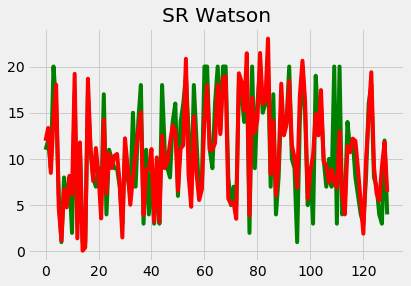

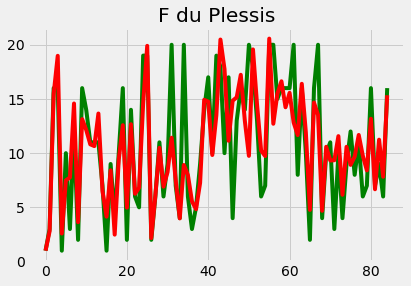

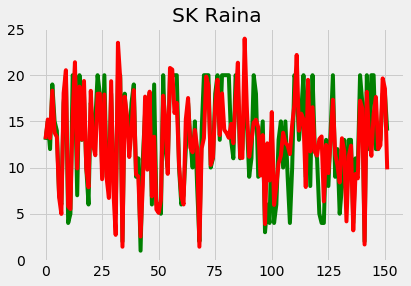

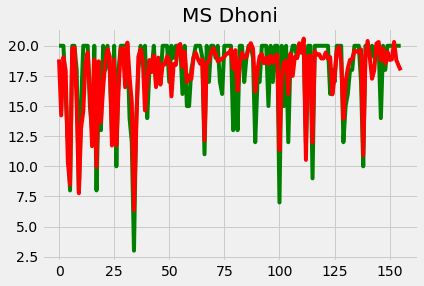

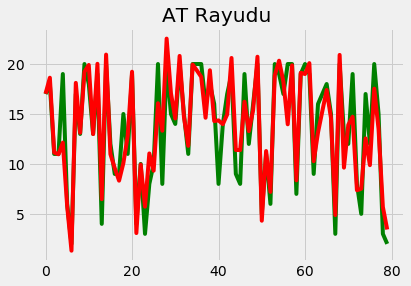

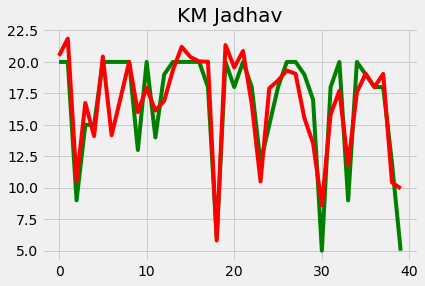

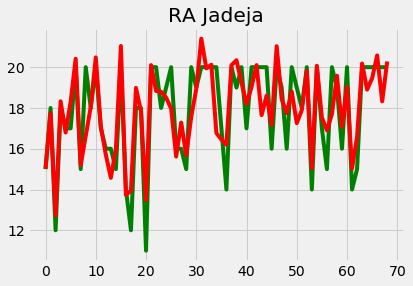

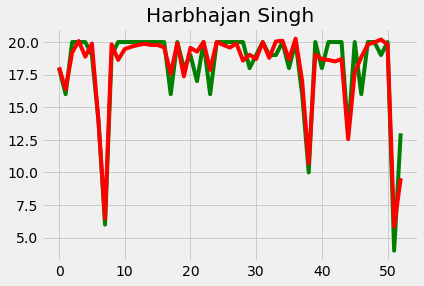

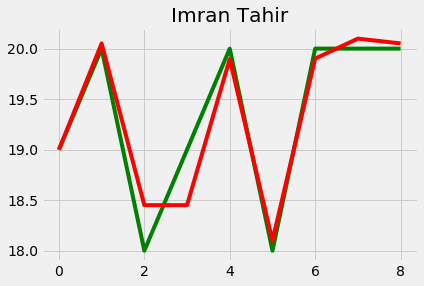

   PLAYER_ID             NAME TEAM TYPE    CR START END  RUNS
0       8180        SR Watson  CSK  BAT  10.0     1  20   0.0
1      44828     F du Plessis  CSK  BAT   9.0     1  18   1.0
2      33335         SK Raina  CSK  BAT   9.5    18  20  13.0
3      28081         MS Dhoni  CSK   WK   9.0    20  20  16.0
4      33141        AT Rayudu  CSK  BAT   9.5    20  20  15.0
5     290716        KM Jadhav  CSK  BAT   9.0    20  20  15.0
6     539548    SC Kuggeleijn  CSK  BOL   8.0    20  20  14.0
7     234675        RA Jadeja  CSK  ALL   8.5    20  20   0.0
8      29264  Harbhajan Singh  CSK  BOL   8.0    20  20   0.0
9     447261        DL Chahar  CSK  BOL   8.5    20  20   0.0
10     40618      Imran Tahir  CSK  BOL   8.5    20  20   0.0
************************************************************************


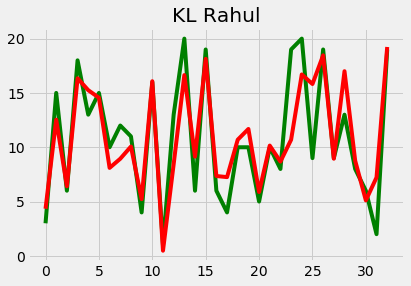

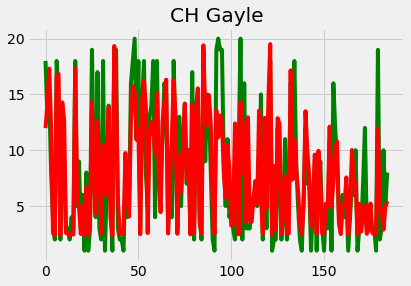

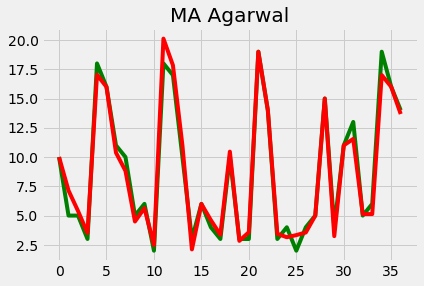

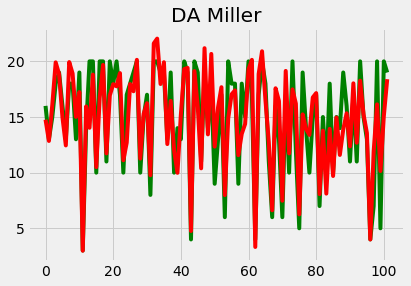

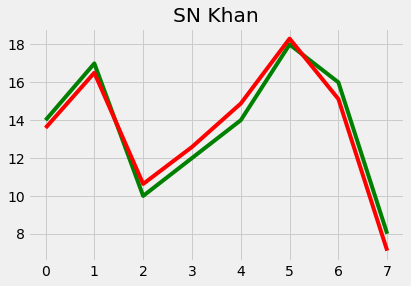

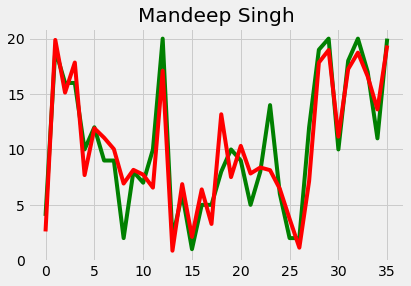

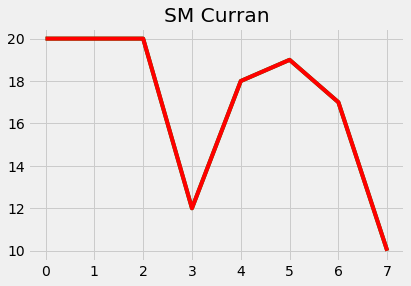

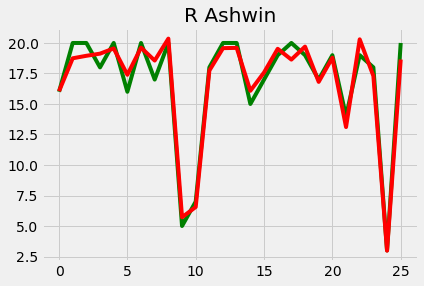

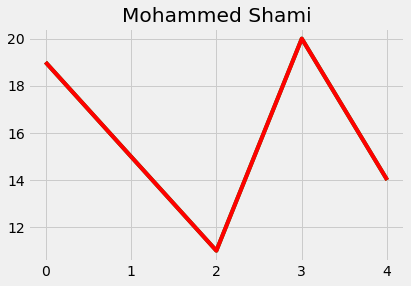

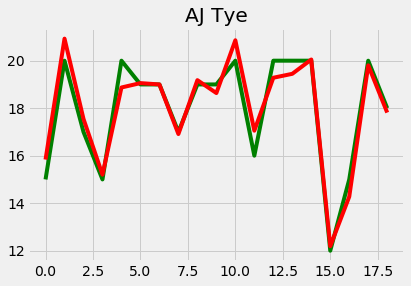

   PLAYER_ID            NAME  TEAM TYPE    CR START END  RUNS
0     422108        KL Rahul  KING   WK  10.0     1  20   0.0
1      51880        CH Gayle  KING  BAT  10.5     1  20   0.0
2     398438      MA Agarwal  KING  BAT   8.0    20  20  17.0
3     321777       DA Miller  KING  BAT   9.0    20  20  15.0
4     642525         SN Khan  KING  BAT   8.0    20  20  18.0
5     398506   Mandeep Singh  KING  BAT   8.0    20  20  15.0
6     662973       SM Curran  KING  ALL   8.5    20  20  13.0
7      26421        R Ashwin  KING  ALL   9.0    20  20   0.0
8     481896  Mohammed Shami  KING  BOL   8.5    20  20   0.0
9     459508          AJ Tye  KING  BOL   9.0    20  20   0.0
10    528067        M Ashwin  KING  BOL   8.0    20  20   0.0
    PLAYER_ID             NAME  TEAM TYPE    CR  RUNS  RNK
2       28081         MS Dhoni   CSK   WK   9.0  16.0  1.0
14     422108         KL Rahul  KING   WK  10.0   0.0  2.0
19     539548    SC Kuggeleijn   CSK  BOL   8.0  14.0  1.0
3       29264  Harbh

In [21]:
def batting_profile(battsmen_id):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BATSMEN_ID == battsmen_id)]
    summary=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME','GROUND','INN']).agg({'BALL':'max'}).reset_index()
    return summary

def ground_performance_bat(ground,pos,inn):
    ground_data=BALL_BY_BALL[(BALL_BY_BALL.GROUND == ground)&(BALL_BY_BALL.INN == inn)]
    order=ground_data.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME','INN']).agg({'BALL':['min','max'],'RUNS':'sum'},axis=0 ).reset_index()
    order.columns = ['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME','INN','RUNS','FIRST','LAST']
    order['POS']=order.groupby(['MATCH_NUMBER','INN'])['FIRST'].rank(ascending=True)
    order=order[(order.POS==pos)]
    avg_out=order.LAST.mean()
    return avg_out

def Batting_order(match_num,inn,batsmen_id):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num) & (BALL_BY_BALL.INN == inn)]
    order=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME']).agg({'BALL':['min','max'],'RUNS':'sum'}).reset_index()
    order.columns = ['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME','RUNS','FIRST','LAST']
    order['POS']=order.groupby('MATCH_NUMBER')['FIRST'].rank(ascending=True)
    order=order[(order.BATSMEN_ID==batsmen_id)]
    pos=order.POS.max()
    over_started=order.FIRST.max()
    over_ended=order.LAST.max()
    return [over_started,pos,over_ended]

def batsmen_avg_out(batsmen_id,pos,inn):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BATSMEN_ID == batsmen_id)&(BALL_BY_BALL.INN == inn)]
    summary=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','INN']).agg({'BALL':'min','RUNS':'sum'}).reset_index()
    avg_out=0.0
    count=0
    cnt=0
    for ind,row in summary.iterrows():
        lst=Batting_order(row['MATCH_NUMBER'],row['INN'],row['BATSMEN_ID'])
        position=lst[1]
        over_ended=lst[2]
        if position==pos:
            avg_out=avg_out+ over_ended
            count=count+1
            cnt=cnt+1
    if count==0:
        count=1
    out=avg_out/count
    return out

def Batting_order_wicket(match_num,inn,bower_id,pos):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num) & (BALL_BY_BALL.INN == inn)]
    order=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME']).agg({'BALL':['min','max'],'RUNS':'sum'}).reset_index()
    order.columns = ['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME','RUNS','FIRST','LAST']
    order['POS']=order.groupby('MATCH_NUMBER')['FIRST'].rank(ascending=True)
    wiket_balls=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == bower_id)& (BALL_BY_BALL.INN == inn) & (BALL_BY_BALL.OUT == True)]
    wiket_balls=wiket_balls[['BOWLER_NAME','BATSMEN_NAME','BOWLER_ID','BATSMEN_ID','BALL']]
    df = pd.merge(wiket_balls,order, how='inner', on=['BATSMEN_ID'])
    df=df[(df.POS == pos)]
    final_avg_out=df.LAST.mean()
        
    return final_avg_out

def pos_avg_bowling(ground,pos,bower_id,inn):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == bower_id) & (BALL_BY_BALL.GROUND == ground) & (BALL_BY_BALL.INN == inn)]
    summary=player_dat.groupby(['MATCH_NUMBER','INN','BOWLER_ID','BOWLER_NAME']).agg({'BALL':'count','DISS':'sum'}).reset_index()
    out_ball_lst=[]
    x=0
    for ind,row in summary.iterrows():
        out_ball=Batting_order_wicket(row['MATCH_NUMBER'],row['INN'],row['BOWLER_ID'],pos)
        if out_ball>=0.0:
            out_ball_lst.insert(x,out_ball)
            x=x+1
    return out_ball_lst

def bowlers_faced_by_batsmen(ground,pos,match_num,inn):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num)&(BALL_BY_BALL.INN == inn)]
    summary=player_dat.groupby(['BOWLER_ID','BOWLER_NAME']).agg({'BALL':'count','DISS':'sum'}).reset_index()
    ball_list=[]
    for ind,row in summary.iterrows():
        lst=pos_avg_bowling(ground,pos,row['BOWLER_ID'],inn)
        ball_list=ball_list+lst
    if len(ball_list)==0:
        avg_ball=0
    else:
        avg_ball=sum(ball_list)/len(ball_list)
    return avg_ball

def bol_vs_bat(bowler_id,batsmen_id,):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == bowler_id) & (BALL_BY_BALL.BATSMEN_ID == batsmen_id) & (BALL_BY_BALL.OUT == True)]
    order=player_dat.groupby(['MATCH_NUMBER']).agg({'BALL':['min','max']}).reset_index()
    order.columns = ['MATCH_NUMBER','FIRST','LAST']
    mean_last_ball=order.LAST.mean()
    if math.isnan(mean_last_ball):
        return 0
    else:
        return mean_last_ball

def bowlers_vs_batsmen(pos,batsmen_id,match_num):   
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num) & (BALL_BY_BALL.BATSMEN_ID == batsmen_id)]  
    summary=player_dat.groupby(['MATCH_NUMBER','INN','BATSMEN_ID','BOWLER_ID']).agg({'BALL':'count','DISS':'sum'}).reset_index()
    lst=[]
    x=0
    for ind,row in summary.iterrows():
        val=bol_vs_bat(row['BOWLER_ID'],row['BATSMEN_ID'])
        position=Batting_order(row['MATCH_NUMBER'],row['INN'],row['BATSMEN_ID'])[1]
        if val >0 and position ==pos:
            lst.insert(x,val)
            x=x+1
    if len(lst) >0:
        mean_val=sum(lst)/len(lst)
    else:
        mean_val=0
    return mean_val  

def cal_totla_runs_wikets_rem(match_num,pos):
    match_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num) & (BALL_BY_BALL.INN == 2)]
    first_inn_df=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num) & (BALL_BY_BALL.INN == 1)]
    first_inn_sum=first_inn_df.RUNS.sum()
    order=match_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME']).agg({'BALL':['min','max'],'RUNS':'sum'}).reset_index()
    order.columns = ['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME','RUNS','FIRST','LAST']
    order['POS']=order.groupby('MATCH_NUMBER')['FIRST'].rank(ascending=True)
    first_ball_faced_df=order[(order.POS == pos)]
    first_ball=first_ball_faced_df.FIRST.max()
    rem_runs_df=match_dat[(match_dat.BALL < first_ball)]
    rem_runs=first_inn_sum-rem_runs_df.RUNS.sum()
    rem_overs=first_ball
    rem_balls=(20-rem_overs)
    if math.isnan(rem_balls):
        rem_balls=0.0
        rem_runs=0.0   
    return [rem_balls,rem_runs]

def return_bolwer_list(team):
    player_data=dream_11_df[(dream_11_df.TEAM != team)]
    bowler_list=list(player_data.PLAYER_ID.unique())
    return bowler_list

def testing_bowling_avg_out(ground,player_list,pos,inn):
    ball_list=[]
    for player in player_list:
        lst=pos_avg_bowling(ground,pos,player,inn)
        ball_list=ball_list+lst
    if len(ball_list)==0:
        avg_ball=0
    else:
        avg_ball=sum(ball_list)/len(ball_list)
    return avg_ball





def test_bowlers_vs_batsmen(pos,bowler_list,batsmen_id):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID.isin(bowler_list)) & (BALL_BY_BALL.BATSMEN_ID == batsmen_id)]
    summary=player_dat.groupby(['MATCH_NUMBER','INN','BATSMEN_ID','BOWLER_ID']).agg({'BALL':'count','DISS':'sum'}).reset_index()
    lst=[]
    x=0
    for ind,row in summary.iterrows():
        val=bol_vs_bat(row['BOWLER_ID'],row['BATSMEN_ID'])
        position=Batting_order(row['MATCH_NUMBER'],row['INN'],row['BATSMEN_ID'])[1]
        if val >0 and pos==position:
            lst.insert(x,val)
            x=x+1
    if len(lst) >0:
        mean_val=sum(lst)/len(lst)
    else:
        mean_val=0
    return mean_val 

def prm_tuning(X,y,nfolds):
    Cs = [x/10.0 for x in range(1,101)]
    param_grid = {'alpha': Cs}
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    model = GridSearchCV(KernelRidge(), param_grid, cv = nfolds,scoring=scorer)
    model.fit(X, y)
    return model.best_params_

def mlp_prm_tuning(X,y,nfolds):
    lst=[]
    ind=0
    for i in range(1,9):
        for j in range(1,9):
            for k in range(1,9):
                tup=(i,j,k)
                lst.insert(ind,tup)
                ind=ind+1                    
    param_grid = {'hidden_layer_sizes': lst}
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    model = GridSearchCV(MLPRegressor(solver='lbfgs',max_iter=10000,random_state=0),param_grid,scoring=scorer, cv = nfolds)
    model.fit(X, y)
    return model.best_params_

def sr_rate(batsmen_id,match_num):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BATSMEN_ID == batsmen_id) & (BALL_BY_BALL.MATCH_NUMBER < match_num)]
    data=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID']).agg({'BALL':'count','RUNS':'sum'}).reset_index()
    data=data.sort_values(['MATCH_NUMBER'], ascending=[False])
    data=data.head(5)
    ball=float(data.BALL.sum())
    runs=float(data.RUNS.sum())
    if ball==0:
        sr=0.0
    else:
        sr=(runs/ball)*100      
    return sr

def test_sr_rate(batsmen_id):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BATSMEN_ID == batsmen_id)]
    data=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID']).agg({'BALL':'count','RUNS':'sum'}).reset_index()
    data=data.sort_values(['MATCH_NUMBER'], ascending=[False])
    data=data.head(5)
    ball=float(data.BALL.sum())
    runs=float(data.RUNS.sum())
    if ball==0:
        sr=0.0
    else:
        sr=(runs/ball)*100     
    return sr

def model_batsmen(batsmen_id):
    batsmen_model=pd.DataFrame(columns=['FIRST','LAST','DIFF','SR','EXP_RUNS','RUNS'])
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BATSMEN_ID == batsmen_id)]
    order=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID']).agg({'BALL':['min','max'],'RUNS':'sum'}).reset_index()
    order.columns = ['MATCH_NUMBER','BATSMEN_ID','RUNS','FIRST','LAST']
    order['DIFF']=order['LAST']-order['FIRST']
    x=0
    for ind, row in order.iterrows():
        sr_avg=sr_rate(row['BATSMEN_ID'],row['MATCH_NUMBER'])
        sr=sr_avg
        exp_runs=(sr/100.00)*(row['DIFF']*6.0)
        if sr >0:
            batsmen_model.loc[x]=[row['FIRST'],row['LAST'],round(row['DIFF'],2),sr,exp_runs,row['RUNS']]
        x=x+1
    return batsmen_model

def bowling_profile(bowler_id):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == bowler_id)]
    summary=player_dat.groupby(['MATCH_NUMBER','BOWLER_ID','BOWLER_NAME','GROUND','INN']).agg({'BALL':'count','RUNS':'sum','DISS':'sum'}).reset_index()
    summary['WICKETS']=summary['DISS']*20
    return summary


def ground_avg_bol(ground,bowler_id):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == bowler_id) & (BALL_BY_BALL.GROUND == ground)]
    summary=player_dat.groupby(['MATCH_NUMBER']).agg({'BALL':'count','RUNS':'sum','DISS':'sum'}).reset_index()
    summary['WICKETS']=summary['DISS']*20
    avg=summary.WICKETS.mean()
    if len(player_dat)>0:
        return avg
    else:
        return 0.0



def head_to_head(bowler,batsmen):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == bowler) & (BALL_BY_BALL.BATSMEN_ID == batsmen)]
    summary=player_dat.groupby(['MATCH_NUMBER','BOWLER_ID','BOWLER_NAME']).agg({'BALL':'count','RUNS':'sum','DISS':'sum'}).reset_index()
    summary['WICKETS']=summary['DISS']*20
    avg_wk=summary.WICKETS.mean()
    if len(summary)>0:
        return avg_wk
    else:
        return 0.0
    
def get_batsmen_avg(bowler_id,match_num):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.MATCH_NUMBER == match_num)]
    batsmen_list=list(player_dat.BATSMEN_ID.unique())
    lst=[]
    x=0
    for bat in batsmen_list:
        val = head_to_head(bowler_id,bat)
        lst.insert(x,val)
        x=x+1
    if len(lst)>0:
        avg=np.mean(lst)
    else:
        avg=0
    return avg

def test_get_batsmen_avg(batsmen_list,bowler_id):
    lst=[]
    x=0
    for bat in batsmen_list:
        val = head_to_head(bowler_id,bat)
        lst.insert(x,val)
        x=x+1
    if len(lst)>0:
        avg=np.mean(lst)
    else:
        avg=0
    return avg         

def check_bowling_con(player_id):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BATSMEN_ID == player_id)]
    batting=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME']).agg({'RUNS':'sum'}).reset_index() 
    player_dat1=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == player_id)]
    bowling=player_dat1.groupby(['MATCH_NUMBER','BOWLER_ID','BOWLER_NAME']).agg({'BALL':'count'}).reset_index()
    result =pd.merge(batting, bowling, on='MATCH_NUMBER', how='outer')
    result=result.fillna(0)
    result=result.sort_values(['MATCH_NUMBER'], ascending=[False])
    result=result.head(5)
    result=result[['BALL']]
    avg_ball=result.BALL.mean()
    if math.isnan(avg_ball) or avg_ball < 6 :
        return 0.0
    else:
        return avg_ball
   
def recent_bowling_performance(bowler_id):
    player_dat=BALL_BY_BALL[(BALL_BY_BALL.BATSMEN_ID == bowler_id) ]
    batting=player_dat.groupby(['MATCH_NUMBER','BATSMEN_ID','BATSMEN_NAME']).agg({'SPEED':'sum'}).reset_index() 
    player_dat1=BALL_BY_BALL[(BALL_BY_BALL.BOWLER_ID == bowler_id)]
    bowling=player_dat1.groupby(['MATCH_NUMBER','BOWLER_ID','BOWLER_NAME']).agg({'BALL':'count','RUNS':'sum','DISS':'sum'}).reset_index()
    result =pd.merge(batting, bowling, on='MATCH_NUMBER', how='outer')
    result=result.fillna(0)
    result=result.sort_values(['MATCH_NUMBER'], ascending=[False])
    result=result.head(2)
    result=result[['BALL','RUNS','DISS']]
    try:
        sr=float(result.BALL.sum())/float(result.DISS.sum())
        avg=float(result.RUNS.sum())/float(result.DISS.sum())
        return [sr,avg]
    except:
        return [0.0,0.0]

def create_best_team(df):
    batting_df=df[(df.TYPE == 'BAT')]
    bowling_df=df[(df.TYPE == 'BOL')]
    allround_df=df[(df.TYPE == 'ALL')]
    wk_df=df[(df.TYPE == 'WK')]
       
    teams=list(df.TEAM.unique())
    team=teams[0]
    
    battting_dct={}
    for ind,row in batting_df.iterrows():
        key=row['NAME'] +'['+row['TEAM']+']'
        battting_dct[key]=[row['CR'],row['RUNS']]

    bowling_dct={}
    for ind,row in bowling_df.iterrows():
        key=row['NAME'] +'['+row['TEAM']+']'
        bowling_dct[key]=[row['CR'],row['RUNS']]

    allround_dct={}
    for ind,row in allround_df.iterrows():
        key=row['NAME'] +'['+row['TEAM']+']'
        allround_dct[key]=[row['CR'],row['RUNS']]

    wk_dct={}
    for ind,row in wk_df.iterrows():
        key=row['NAME'] +'['+row['TEAM']+']'
        wk_dct[key]=[row['CR'],row['RUNS']]
        
    posibule_cobs=[[1,5,2,3],[1,5,1,4],[1,4,1,5],[1,4,2,4],[1,4,3,3],[1,3,2,5],[1,3,3,4]]
    
    all_posibulel_team={}
    for lst in posibule_cobs:
        wk_count=lst[0] 
        bat_count=lst[1]
        all_count=lst[2]
        bol_count=lst[3]

        batting_comb = map(dict, itertools.combinations(battting_dct.items(),bat_count))
        new_btting_dict={}
        for comb in batting_comb:
            cr_sum=0
            runs_sum=0
            player_lst=[]
            x=0
            for key,val in comb.items():
                cr_sum=cr_sum+val[0]
                runs_sum=runs_sum+val[1]
                player_lst.insert(x,key)
                x=x+1
            new_btting_dict[tuple(player_lst)]=[cr_sum,runs_sum]

        bowling_comb = map(dict, itertools.combinations(bowling_dct.items(),bol_count))
        new_bowling_dict={}
        for comb in bowling_comb:
            cr_sum=0
            runs_sum=0
            player_lst=[]
            x=0
            for key,val in comb.items():
                cr_sum=cr_sum+val[0]
                runs_sum=runs_sum+val[1]
                player_lst.insert(x,key)
                x=x+1
            new_bowling_dict[tuple(player_lst)]=[cr_sum,runs_sum]

        allround_comb = map(dict, itertools.combinations(allround_dct.items(),all_count))
        new_allround_dict={}
        for comb in allround_comb:
            cr_sum=0
            runs_sum=0
            player_lst=[]
            x=0
            for key,val in comb.items():
                cr_sum=cr_sum+val[0]
                runs_sum=runs_sum+val[1]
                player_lst.insert(x,key)
                x=x+1
            new_allround_dict[tuple(player_lst)]=[cr_sum,runs_sum]

        wk_comb = map(dict, itertools.combinations(wk_dct.items(),wk_count))
        new_wk_dict={}
        for comb in wk_comb:
            cr_sum=0
            runs_sum=0
            player_lst=[]
            x=0
            for key,val in comb.items():
                cr_sum=cr_sum+val[0]
                runs_sum=runs_sum+val[1]
                player_lst.insert(x,key)
                x=x+1
            new_wk_dict[tuple(player_lst)]=[cr_sum,runs_sum]      
    
        bat_bol_comb_dict={}
        for key,val in new_btting_dict.items():
            for k,v in new_bowling_dict.items():
                bat_bol_comb_dict[key+k]=[val[0]+v[0],val[1]+v[1]]
            
        bat_bol_all_comb_dict={}
        for key,val in bat_bol_comb_dict.items():
            for k,v in new_allround_dict.items():
                bat_bol_all_comb_dict[key+k]=[val[0]+v[0],val[1]+v[1]]
            
        bat_bol_all_wk_comb_dict={}
        for key,val in bat_bol_all_comb_dict.items():
            for k,v in new_wk_dict.items():
               bat_bol_all_wk_comb_dict[key+k]=[val[0]+v[0],val[1]+v[1]]
            
        resutl_dict={}
        for key,val in bat_bol_all_wk_comb_dict.items():
            count=0
            for player in key:
                if team in player:
                    count=count+1
            if (count >=4 and count <=7) and val[0]<=100 :
                resutl_dict[key]=val
        all_posibulel_team.update(resutl_dict)
    return all_posibulel_team   





TUNING_DF_OUT=pd.read_csv('ML_PRM_BAT_OUT_INN_1.csv',skipinitialspace=True)
TUNING_DF_RUNS=pd.read_csv('ML_PRM_BAT_RUNS.csv',skipinitialspace=True)

INN_1_BATTING_DF=pd.DataFrame(columns=['PLAYER_ID','NAME','TEAM','TYPE','CR','START','END','RUNS'])

x=0   
opening_dict={} 
dream_11_df=dream_11_df.sort_values(['TEAM','POS'], ascending=[True,True])
for ind,row in dream_11_df.iterrows(): 
    if row['INN']==1:
        if row['POS']==1:
            over_started=1
        elif row['POS']==2:
            over_started=1       
        position=row['POS']
        ground_avg_out=ground_performance_bat(row['GROUND'],position,row['INN'])
        bat_avg_out=batsmen_avg_out(row['PLAYER_ID'],position,row['INN'])
        bowler_avg_out= testing_bowling_avg_out(row['GROUND'],return_bolwer_list(row['TEAM']),position,row['INN'])
        team_eff=test_bowlers_vs_batsmen(row['POS'],return_bolwer_list(row['TEAM']),row['PLAYER_ID'])
        
        if bat_avg_out==0:
            bat_avg_out=ground_avg_out
            
        if bowler_avg_out==0:
            bowler_avg_out=(ground_avg_out+bat_avg_out)/2  
                
        if team_eff==0:
            team_eff=(ground_avg_out+bowler_avg_out+bat_avg_out)/3
    
        avg=(team_eff+bowler_avg_out)/2
        TEST_DF=pd.DataFrame(columns=['POSITION','OVER_STARTED','GROUND_AVG','AVG_OUT','BOL_AVG_OUT','TEAM_EFF','AVG'])
        TEST_DF.loc[0]=[
                position,
                math.ceil(over_started),
                round(ground_avg_out),
                round(bat_avg_out),
                round(bowler_avg_out),
                round(team_eff),
                round(avg)
                ]

        out_pridict=TEST_DF[['POSITION','OVER_STARTED','GROUND_AVG','AVG_OUT','BOL_AVG_OUT','TEAM_EFF','AVG']]
        if True:
            try :
                DATA = pd.read_csv(str(row['PLAYER_ID'])+'_INN_1_BAT.csv',skipinitialspace=True)
                DATA=DATA.reset_index(drop=True)
                X=DATA[['POSITION','OVER_STARTED','GROUND_AVG','AVG_OUT','BOL_AVG_OUT','TEAM_EFF','AVG']]
                y=DATA.OUT.values.ravel() 
                
                
                player_df=TUNING_DF_OUT[(TUNING_DF_OUT.PLAYER_ID == row['PLAYER_ID'])]
                player_df=player_df.reset_index(drop=True)
                score=player_df.SCORE.max()
                
                if score>0:
                    tup=player_df.iloc[0]['HIDDEN_LAYER']
                    ind=0
                    lst=[]
                    for j in tup:
                        try:
                            val=int(j)
                            lst.insert(ind,val)
                            ind=ind+1
                        except:
                            dummy=[]
                    tup=tuple(lst)      
                    player_reg_out =MLPRegressor(hidden_layer_sizes=tup,solver='lbfgs',max_iter=10000,random_state=0)
                    player_reg_out.fit(X,y)
                    y_pridict=player_reg_out.predict(X)
                    
                    try:
                        plt.style.use('fivethirtyeight')
                        plt.title(row['PLAYER_NAME'])
                        plt.plot(DATA.index,y,color='green',label='ACTUAL RUNS')
                        plt.plot(DATA.index,y_pridict,color='red',label='PRIDICTED RUNS')
                        plt.show()
                    except:
                        print()
                    
                    prid_val=math.ceil(player_reg_out.predict(out_pridict)[0])
                else:
                    prid_val=0.0  
            except:
                prid_val=0.0
                
            if prid_val >20:
                prid_val=20
            if row['POS'] >=8:
                prid_val=over_started
            if prid_val<over_started:
                prid_val=over_started
                
                
            batsmen_df=model_batsmen(row['PLAYER_ID'])
            X_bat=batsmen_df[['FIRST','LAST','DIFF']]
            y_bat=batsmen_df.RUNS.values.ravel()
            
            test_bat=pd.DataFrame(columns=['FIRST','LAST','DIFF'])
            sr=test_sr_rate(row['PLAYER_ID'])
            exp_runs=(sr*(prid_val-over_started)*6.0)/100.0
            test_bat.loc[0]=[over_started,prid_val,prid_val-over_started]
            test_bat=test_bat.fillna(0)
            x_prid=test_bat[['FIRST','LAST','DIFF']]
            try:
                player_df=TUNING_DF_RUNS[(TUNING_DF_RUNS.PLAYER_ID == row['PLAYER_ID'])]
                score=player_df.SCORE.max()
                if score>0:
                    tup=player_df.iloc[0]['HIDDEN_LAYER']
                    ind=0
                    lst=[]
                    for j in tup:
                        try:
                            val=int(j)
                            lst.insert(ind,val)
                            ind=ind+1
                        except:
                            dummy=[]
                    tup=tuple(lst)
                    reg_bat = MLPRegressor(hidden_layer_sizes=tup,solver='lbfgs',max_iter=10000,random_state=0)
                    reg_bat.fit(X_bat,y_bat)
                    runs_pridicted=round(reg_bat.predict(x_prid)[0])
                else:
                    runs_pridicted=0.0
            except:
                runs_pridicted=0.0
            if row['POS'] >7:
                runs_pridicted=0 
            INN_1_BATTING_DF.loc[x]=[row['PLAYER_ID'],row['PLAYER_NAME'],row['TEAM'],row['TYPE'],row['CR'],over_started,prid_val,runs_pridicted]
            x=x+1
            
            if row['POS'] ==1:
                opening_dict[1]=prid_val
            
            elif row['POS'] ==2:
                opening_dict[2]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
                opening_dict[key_min]=prid_val
            
            elif row['POS'] ==3:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
                
            elif row['POS'] ==4:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val        

            elif row['POS'] ==5:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
                 
            elif row['POS'] ==6:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
            
            elif row['POS'] ==7:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
            
            elif row['POS'] ==8:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val 

            elif row['POS'] ==9:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
            
            elif row['POS'] ==10:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
            
            elif row['POS'] ==11:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val

print(INN_1_BATTING_DF)
print ('************************************************************************')
TUNING_DF_OUT=pd.read_csv('ML_PRM_BAT_OUT_INN_2.csv',skipinitialspace=True)
INN_2_BATTING_DF=pd.DataFrame(columns=['PLAYER_ID','NAME','TEAM','TYPE','CR','START','END','RUNS'])
x=0   
opening_dict={} 
dream_11_df=dream_11_df.sort_values(['TEAM','POS'], ascending=[True,True])
sum_first_inn_runs=int(INN_1_BATTING_DF.RUNS.sum())
second_inn_runs=0
for ind,row in dream_11_df.iterrows(): 
    if row['INN']==2:
        if row['POS']==1:
            over_started=1
        elif row['POS']==2:
            over_started=1       
        position=row['POS']
        ground_avg_out=ground_performance_bat(row['GROUND'],position,row['INN'])
        bat_avg_out=batsmen_avg_out(row['PLAYER_ID'],position,row['INN'])
        bowler_avg_out= testing_bowling_avg_out(row['GROUND'],return_bolwer_list(row['TEAM']),position,row['INN'])
        team_eff=test_bowlers_vs_batsmen(row['POS'],return_bolwer_list(row['TEAM']),row['PLAYER_ID'])        
        
        if bat_avg_out==0:
            bat_avg_out=ground_avg_out
            
        if bowler_avg_out==0:
            bowler_avg_out=(ground_avg_out+bat_avg_out)/2  

        if team_eff==0:
            team_eff=(ground_avg_out+bowler_avg_out+bat_avg_out)/3

        if row['POS']==1 or row['POS']==2:
            rem_runs=sum_first_inn_runs
            rem_balls=20.0
        else:
            rem_runs=sum_first_inn_runs-second_inn_runs
            rem_balls=20-over_started
        avg=(team_eff+bowler_avg_out)/2
        TEST_DF=pd.DataFrame(columns=['POSITION','OVER_STARTED','GROUND_AVG','AVG_OUT','BOL_AVG_OUT','TEAM_EFF','AVG','REM_RUNS','BALLS'])
        TEST_DF.loc[0]=[
                position,
                math.ceil(over_started),
                round(ground_avg_out),
                round(bat_avg_out),
                round(bowler_avg_out),
                round(team_eff),
                round(avg),
                rem_runs,
                rem_balls
                ]
        out_pridict=TEST_DF[['POSITION','OVER_STARTED','GROUND_AVG','AVG_OUT','BOL_AVG_OUT','TEAM_EFF','AVG']]
        if True:
            try :
                DATA = pd.read_csv(str(row['PLAYER_ID'])+'_INN_2_BAT.csv',skipinitialspace=True)
                X=DATA[['POSITION','OVER_STARTED','GROUND_AVG','AVG_OUT','BOL_AVG_OUT','TEAM_EFF','AVG']]
                y=DATA.OUT.values.ravel() 
                
                player_df=TUNING_DF_OUT[(TUNING_DF_OUT.PLAYER_ID == row['PLAYER_ID'])]
                score=player_df.SCORE.max()
                if score>0:
                    tup=player_df.iloc[0]['HIDDEN_LAYER']
                    ind=0
                    lst=[]
                    for j in tup:
                        try:
                            val=int(j)
                            lst.insert(ind,val)
                            ind=ind+1
                        except:
                            dummy=[]
                    tup=tuple(lst)
                    player_reg_out =MLPRegressor(hidden_layer_sizes=tup,solver='lbfgs',max_iter=10000,random_state=0)
                    player_reg_out.fit(X,y)
                    prid_val=math.ceil(player_reg_out.predict(out_pridict)[0])
                    
                    y_pridict=player_reg_out.predict(X)
                    
                    try:
                        plt.style.use('fivethirtyeight')
                        plt.title(row['PLAYER_NAME'])
                        plt.plot(DATA.index,y,color='green',label='ACTUAL RUNS')
                        plt.plot(DATA.index,y_pridict,color='red',label='PRIDICTED RUNS')
                        plt.show()
                    except:
                        print()
                    
                else:
                    prid_val=0.0
            except:
                prid_val=0.0
                
            if prid_val >20:
                prid_val=20
            if row['POS'] >7:
                prid_val=over_started
            if prid_val<over_started:
                prid_val=over_started
                
            batsmen_df=model_batsmen(row['PLAYER_ID'])
            X_bat=batsmen_df[['FIRST','LAST','DIFF']]
            y_bat=batsmen_df.RUNS.values.ravel()
            
            test_bat=pd.DataFrame(columns=['FIRST','LAST','DIFF'])
            sr=test_sr_rate(row['PLAYER_ID'])
            exp_runs=(sr*(prid_val-over_started)*6.0)/100.0
            test_bat.loc[0]=[over_started,prid_val,prid_val-over_started]
            test_bat=test_bat.fillna(0)
            x_prid=test_bat[['FIRST','LAST','DIFF']]
            try:
                player_df=TUNING_DF_RUNS[(TUNING_DF_RUNS.PLAYER_ID == row['PLAYER_ID'])]
                score=player_df.SCORE.max()
                if score>0:
                    tup=player_df.iloc[0]['HIDDEN_LAYER']
                    ind=0
                    lst=[]
                    for j in tup:
                        try:
                            val=int(j)
                            lst.insert(ind,val)
                            ind=ind+1
                        except:
                            dummy=[]
                    tup=tuple(lst)
                    reg_bat = MLPRegressor(hidden_layer_sizes=tup,solver='lbfgs',max_iter=10000,random_state=0)
                    reg_bat.fit(X_bat,y_bat)
                    runs_pridicted=round(reg_bat.predict(x_prid)[0])
                else:
                    runs_pridicted=0.0
            except:
                runs_pridicted=0.0
                
            if rem_runs<=0:
                runs_pridicted=0.0
            if row['POS'] >8:
               runs_pridicted=0.0 
                
            second_inn_runs=second_inn_runs+runs_pridicted
            INN_2_BATTING_DF.loc[x]=[row['PLAYER_ID'],row['PLAYER_NAME'],row['TEAM'],row['TYPE'],row['CR'],over_started,prid_val,runs_pridicted]
            x=x+1
            
            if row['POS'] ==1:
                opening_dict[1]=prid_val
            
            elif row['POS'] ==2:
                opening_dict[2]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
                opening_dict[key_min]=prid_val
            
            elif row['POS'] ==3:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
                
            elif row['POS'] ==4:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val        

            elif row['POS'] ==5:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
                 
            elif row['POS'] ==6:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
            
            elif row['POS'] ==7:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
            
            elif row['POS'] ==8:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val 

            elif row['POS'] ==9:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
            
            elif row['POS'] ==10:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val
            
            elif row['POS'] ==11:
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                opening_dict[key_min]=prid_val
                key_min = min(opening_dict.keys(), key=(lambda k: opening_dict[k]))
                min_val=opening_dict[key_min]
                over_started=min_val


print(INN_2_BATTING_DF)

##BOWLING PRIDICTION ***********************************************************
TUNING_DF=pd.read_csv('ML_PRM_BOL_WK.csv',skipinitialspace=True)

x=0
BOWLING_DF=pd.DataFrame(columns=['PLAYER_ID','NAME','TEAM','TYPE','CR','RUNS'])
for ind,row in dream_11_df.iterrows():
    if True:
        ground_avg=ground_avg_bol(row['GROUND'],row['PLAYER_ID'])
        batsmen_avg=test_get_batsmen_avg(return_bolwer_list(row['TEAM']),row['PLAYER_ID'])
        lst=recent_bowling_performance(row['PLAYER_ID'])
        avg_wk=lst[1]
        std=lst[0]
        TEST_WK_INN=pd.DataFrame(columns=['GROUND_AVG','BAT_AVG','BOL_AVG','BOL_SR'])
        TEST_WK_INN.loc[0]=[ground_avg,batsmen_avg,avg_wk,std]
        test_x=TEST_WK_INN[['GROUND_AVG','BAT_AVG','BOL_AVG','BOL_SR']]
        val=check_bowling_con(row['PLAYER_ID'])
        if val >0:
            try:
                DATA = pd.read_csv(str(row['PLAYER_ID'])+'_BOL.csv',skipinitialspace=True)
                X=DATA[['GROUND_AVG','BAT_AVG','BOL_AVG','BOL_SR']]
                y=DATA.WK.values.ravel()
                
                
                player_df=TUNING_DF[(TUNING_DF.PLAYER_ID == row['PLAYER_ID'])]
                score=player_df.SCORE.max()
                if score>0:
                    tup=player_df.iloc[0]['HIDDEN_LAYER']
                    ind=0
                    lst=[]
                    for j in tup:
                        try:
                            val=int(j)
                            lst.insert(ind,val)
                            ind=ind+1
                        except:
                            dummy=[]
                    tup=tuple(lst)
                    reg_bol =MLPRegressor(hidden_layer_sizes=tup,solver='lbfgs',max_iter=10000,random_state=0)
                    reg_bol.fit(X,y)
                    wk=round(reg_bol.predict(test_x))
                    
                else:
                    wk=0.0
            except:
                wk=0.0 
        else:
            wk=0.0
        BOWLING_DF.loc[x]=[row['PLAYER_ID'],row['PLAYER_NAME'],row['TEAM'],row['TYPE'],row['CR'],wk]
        x=x+1


BATTING_SCORE_CARD=INN_1_BATTING_DF.append(INN_2_BATTING_DF)
SCORE_CARD=BATTING_SCORE_CARD[['PLAYER_ID','NAME','TEAM','TYPE','CR','RUNS']]

FINAL_RESULT=SCORE_CARD.append(BOWLING_DF)
result=FINAL_RESULT.groupby(['PLAYER_ID','NAME','TEAM','TYPE','CR']).agg({'RUNS':'sum'}).reset_index()
result['RNK']=result.groupby('TYPE')['RUNS'].rank(ascending=False)
result=result.sort_values(['TYPE','RUNS'], ascending=[False,False])

print (result)

comb_dict=create_best_team(result)
result_df=pd.DataFrame(comb_dict.items(), columns=['TEAM', 'SCORE'])
result_df[['CR','RUNS']] = pd.DataFrame(result_df.SCORE.values.tolist(), index= result_df.index)
top_teams=result_df.nlargest(6, 'RUNS')
print('**********************************************************************************************************')
print('The Best teams for fantacy cricket')
for ind,row in top_teams.iterrows():
    team=list(row['TEAM'])
    print ('*******************************:',row['CR'],row['RUNS'])
    for player in team:
        print (player)
